# Utilizarea Google Colab cu GPU și Modele Pre-antrenate de pe Hugging Face

**Google Colab** este o platformă gratuită care permite rularea notebook-urilor Jupyter în cloud, oferind acces la resurse hardware precum **GPU-uri** și **TPU-uri**. Aceasta face posibilă antrenarea și implementarea modelelor complexe de învățare profundă fără a necesita hardware local puternic.

**Hugging Face** oferă o gamă largă de modele pre-antrenate pentru diferite sarcini de învățare automată, inclusiv procesarea limbajului natural (NLP) și procesarea imaginilor (Computer Vision). Aceste modele pot fi utilizate atât pentru **inferență** pe date noi, cât și pentru **fine-tuning** pe seturi de date personalizate.

În acest ghid, vom explora cum puteți utiliza Google Colab cu GPU pentru:

1. **Procesarea imaginilor**: utilizarea modelelor pre-antrenate pentru inferență și fine-tuning.
2. **Procesarea limbajului natural**: utilizarea modelelor pre-antrenate pentru inferență și fine-tuning.

---

## **Configurarea Google Colab pentru a utiliza un GPU**

Indiferent de sarcina pe care o aveți, primul pas este să configurați mediul de lucru pentru a utiliza un GPU.

1. **Deschideți un notebook Colab:**

   Accesați [Google Colab](https://colab.research.google.com/) și creați un nou notebook sau deschideți unul existent.

2. **Selectați un GPU ca accelerator hardware:**

   - Navigați la meniul **"Runtime"** (sau **"Executare"**).
   - Selectați **"Change runtime type"** (sau **"Modifică tipul de runtime"**).
   - În câmpul **"Hardware accelerator"**, alegeți **"GPU"**.
   - Apăsați **"Save"** (sau **"Salvează"**).

---

# **Partea 1: Procesarea Imaginilor cu Modele Hugging Face**

Modelele pre-antrenate pentru imagini pot fi folosite pentru diverse sarcini precum clasificarea imaginilor, detectarea obiectelor sau segmentarea semantică. Vom exemplifica utilizarea unui model pentru **clasificarea imaginilor**.

## **1. Utilizarea Modelelor Pre-antrenate pentru Inferență pe Imagini**

### **Pasul 1: Instalarea Bibliotecilor Necesare**



In [1]:
!pip install transformers
!pip install torch
!pip install torchvision
!pip install pillow

### **Pasul 2: Importarea și Încărcarea Modelului**

Vom folosi modelul **Vision Transformer (ViT)** pre-antrenat pe ImageNet.

In [3]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
from PIL import Image
import requests

# Alegem modelul pre-antrenat
model_name = 'google/vit-base-patch16-224'

# Încărcăm extractorul de caracteristici și modelul
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

### **Pasul 3: Pregătirea Imaginii și Efectuarea Inferenței**

In [4]:
# Obținem o imagine de test
url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bees_image_demo.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Preprocesăm imaginea
inputs = feature_extractor(images=image, return_tensors="pt")

# Mutăm modelul și datele pe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Efectuăm inferența
with torch.no_grad():
    outputs = model(**inputs)

# Obținem predicțiile
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Clasa prezisă:", model.config.id2label[predicted_class_idx])

**Rezultat așteptat:**

```
Clasa prezisă: honeybee
```

---

## **2. Fine-tuning al unui Model Pre-antrenat pe un Set de Date de Imagini**

Vom efectua fine-tuning al modelului ViT pe setul de date **EuroSAT**, care conține imagini satelitare clasificate în 10 categorii.

### **Pasul 1: Instalarea Bibliotecilor Suplimentare**


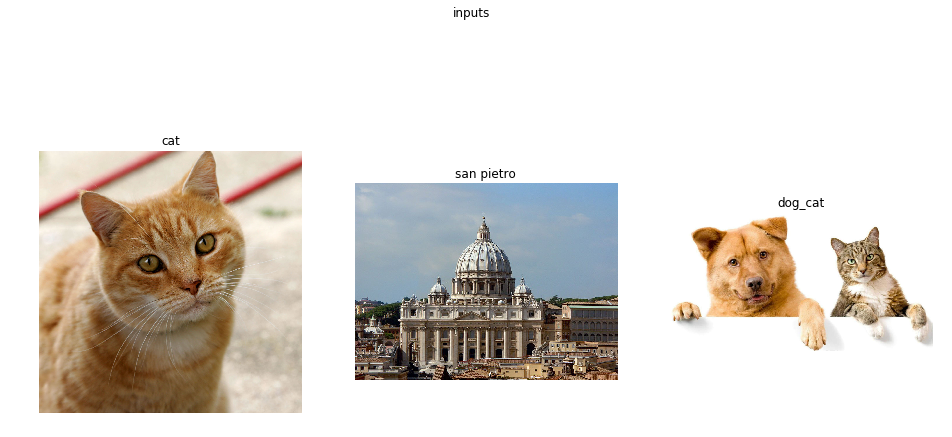

In [5]:
!pip install datasets

### **Pasul 2: Importarea Bibliotecilor și Încărcarea Setului de Date**

In [6]:
from datasets import load_dataset

# Încărcăm setul de date EuroSAT
dataset = load_dataset("eurosat", "rgb", split='train[:2000]')

### **Pasul 3: Preprocesarea Datelor**

In [7]:
def preprocess_images(examples):
    images = [Image.fromarray(img.astype('uint8'), 'RGB') for img in examples['image']]
    inputs = feature_extractor(images=images, return_tensors='pt')
    inputs['labels'] = examples['label']
    return inputs

# Aplicăm preprocesarea pe setul de date
prepared_dataset = dataset.map(preprocess_images, batched=True)

### **Pasul 4: Crearea DataLoader-elor**

In [8]:
from torch.utils.data import DataLoader

# Eliminăm coloanele inutile
prepared_dataset = prepared_dataset.remove_columns(['filename', 'image'])

# Creăm DataLoader-ul
train_dataloader = DataLoader(prepared_dataset, batch_size=8, shuffle=True)

[(0, 'tench Tinca tinca'), (1, 'goldfish Carassius auratus')]

### **Pasul 5: Configurarea Optimizer-ului și a Scheduler-ului**

In [9]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Dropout(p=0.5),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace),
 Linear(in_features=4096, out_features=1000, bias=True)]

### **Pasul 6: Antrenarea Modelului**

In [10]:
from tqdm.auto import tqdm

model.train()
model.to(device)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

### **Pasul 7: Evaluarea Modelului**

Pentru simplitate, vom evalua modelul pe același set de date de antrenament.

torch.Size([1, 27, 27])


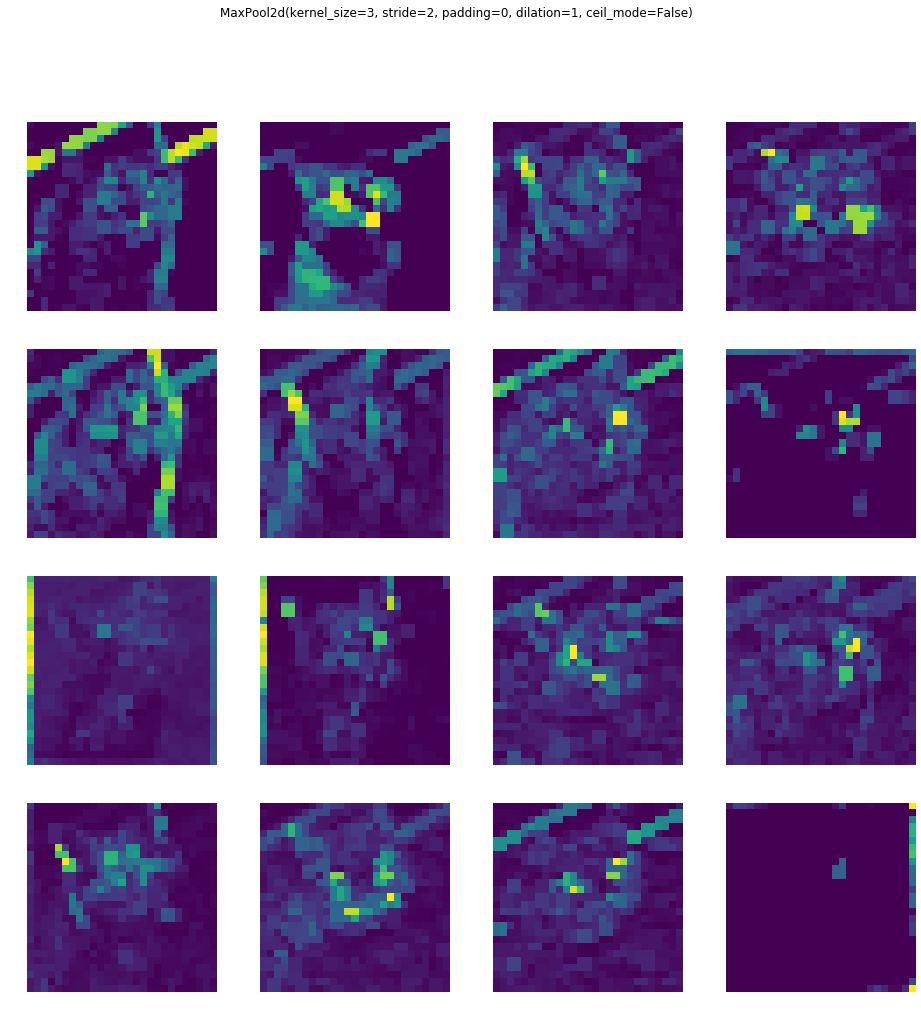

In [12]:
model.eval()

correct = 0
total = 0

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == batch['labels']).sum().item()
    total += predictions.size(0)

accuracy = correct / total
print(f"Acuratețea pe setul de antrenament: {accuracy * 100:.2f}%")

# **Partea 2: Procesarea Limbajului Natural cu Modele Hugging Face**

Modelele pre-antrenate pentru NLP pot fi utilizate pentru sarcini precum clasificarea textului, traducere, rezumare și multe altele.

## **1. Utilizarea Modelelor Pre-antrenate pentru Inferență pe Text**

### **Pasul 1: Instalarea Bibliotecilor Necesare**


torch.Size([1, 27, 27])


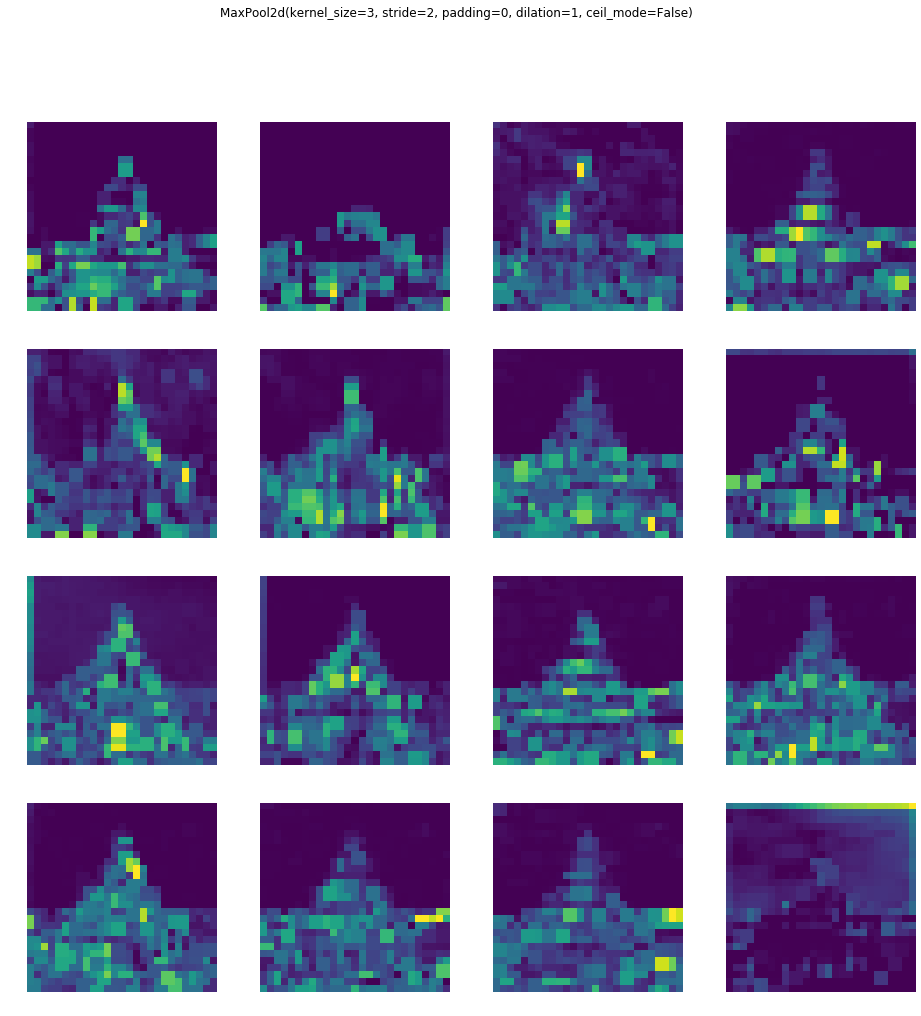

In [13]:
!pip install transformers
!pip install torch

### **Pasul 2: Importarea și Încărcarea Modelului**

Vom utiliza modelul **BERT** pre-antrenat pentru clasificare.


torch.Size([1, 13, 13])


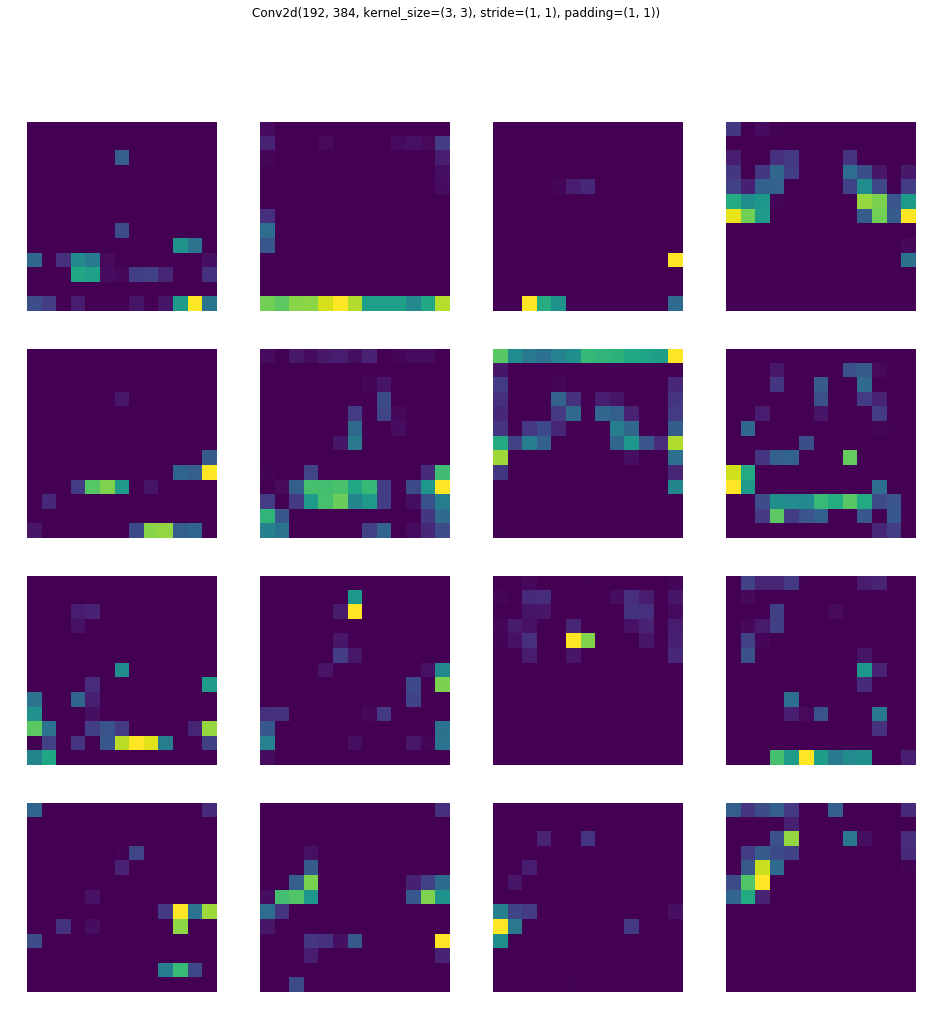

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Alegem modelul pre-antrenat
model_name = "bert-base-uncased"

# Încărcăm tokenizer-ul și modelul
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

### **Pasul 3: Pregătirea Textului și Efectuarea Inferenței**

torch.Size([1, 55, 55])
torch.Size([1, 55, 55])


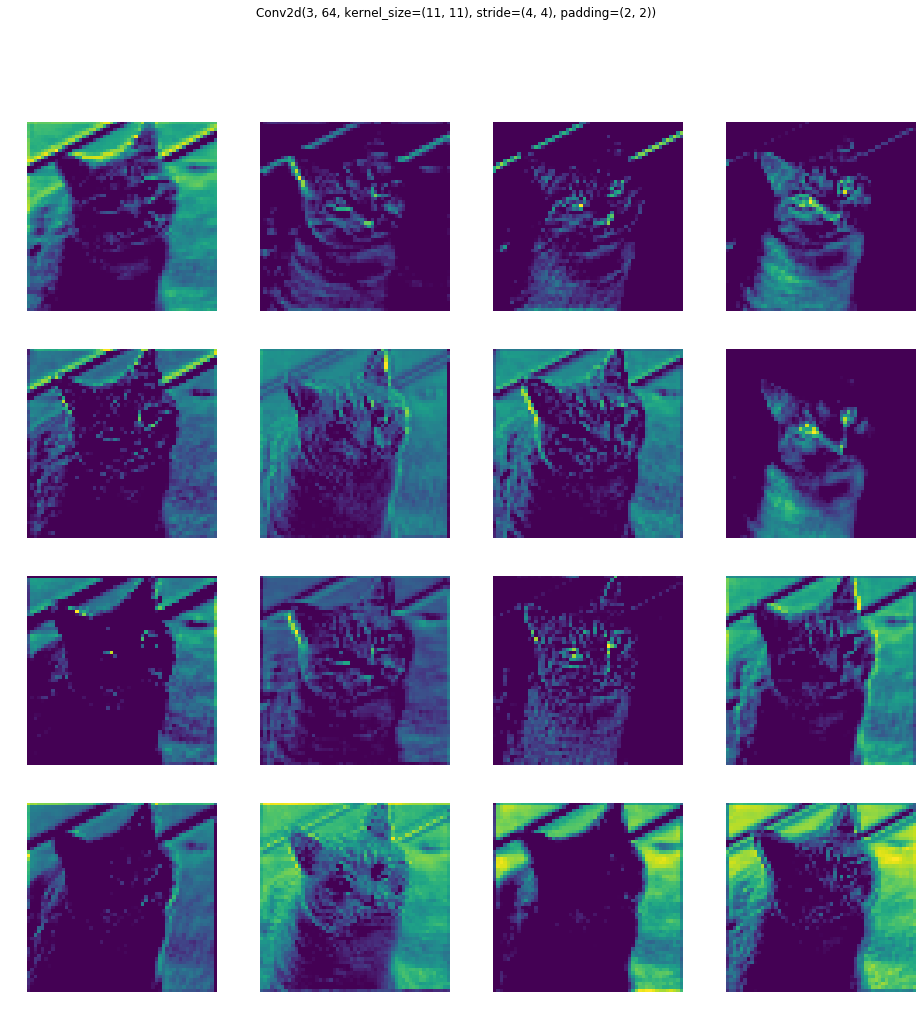

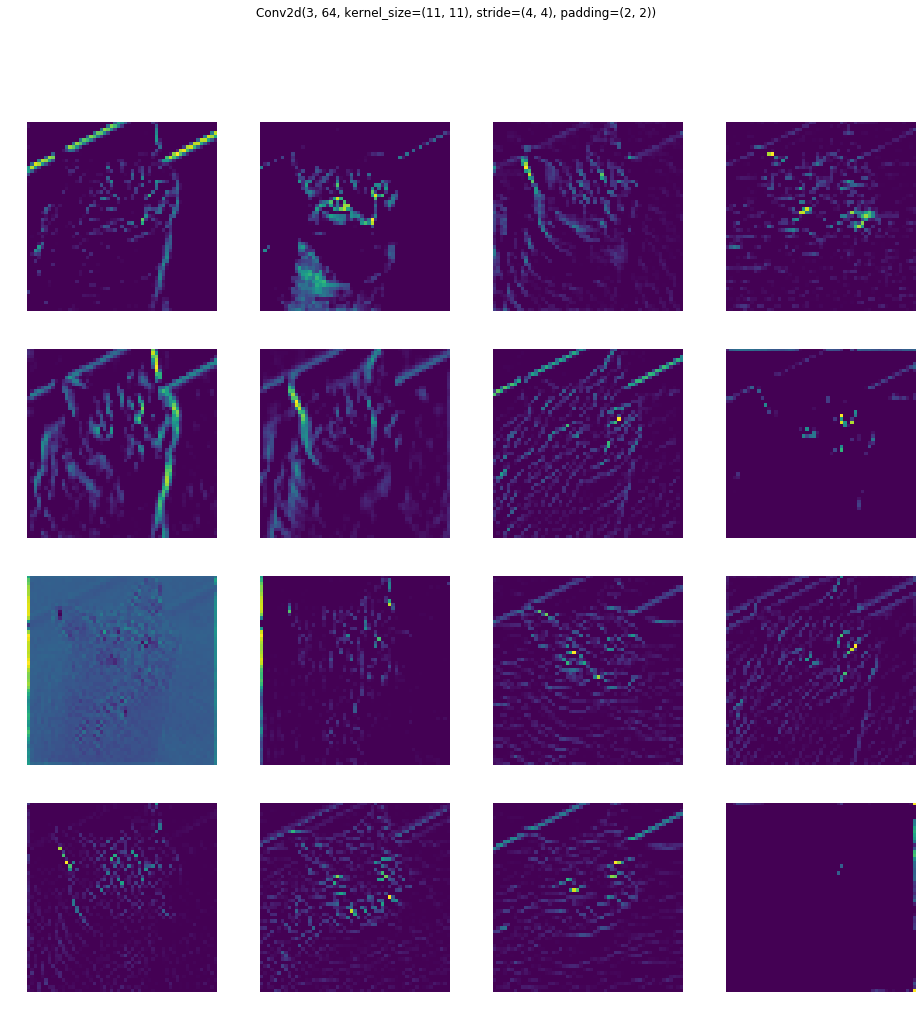

In [15]:
import torch

# Textul pe care dorim să îl clasificăm
text = "I love using Hugging Face transformers!"

# Tokenizarea textului
inputs = tokenizer(text, return_tensors="pt")

# Mutăm modelul și datele pe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Efectuăm inferența
with torch.no_grad():
    outputs = model(**inputs)

# Obținem predicțiile
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1)
print(f"Clasa prezisă: {predicted_class.item()}")

## **2. Fine-tuning al unui Model Pre-antrenat pe Date Noi**

Vom efectua fine-tuning al modelului BERT pe setul de date **IMDb** pentru clasificarea sentimentelor.

### **Pasul 1: Instalarea Bibliotecilor Suplimentare**


In [ ]:
!pip install datasets

### **Pasul 2: Importarea Bibliotecilor și Încărcarea Setului de Date**

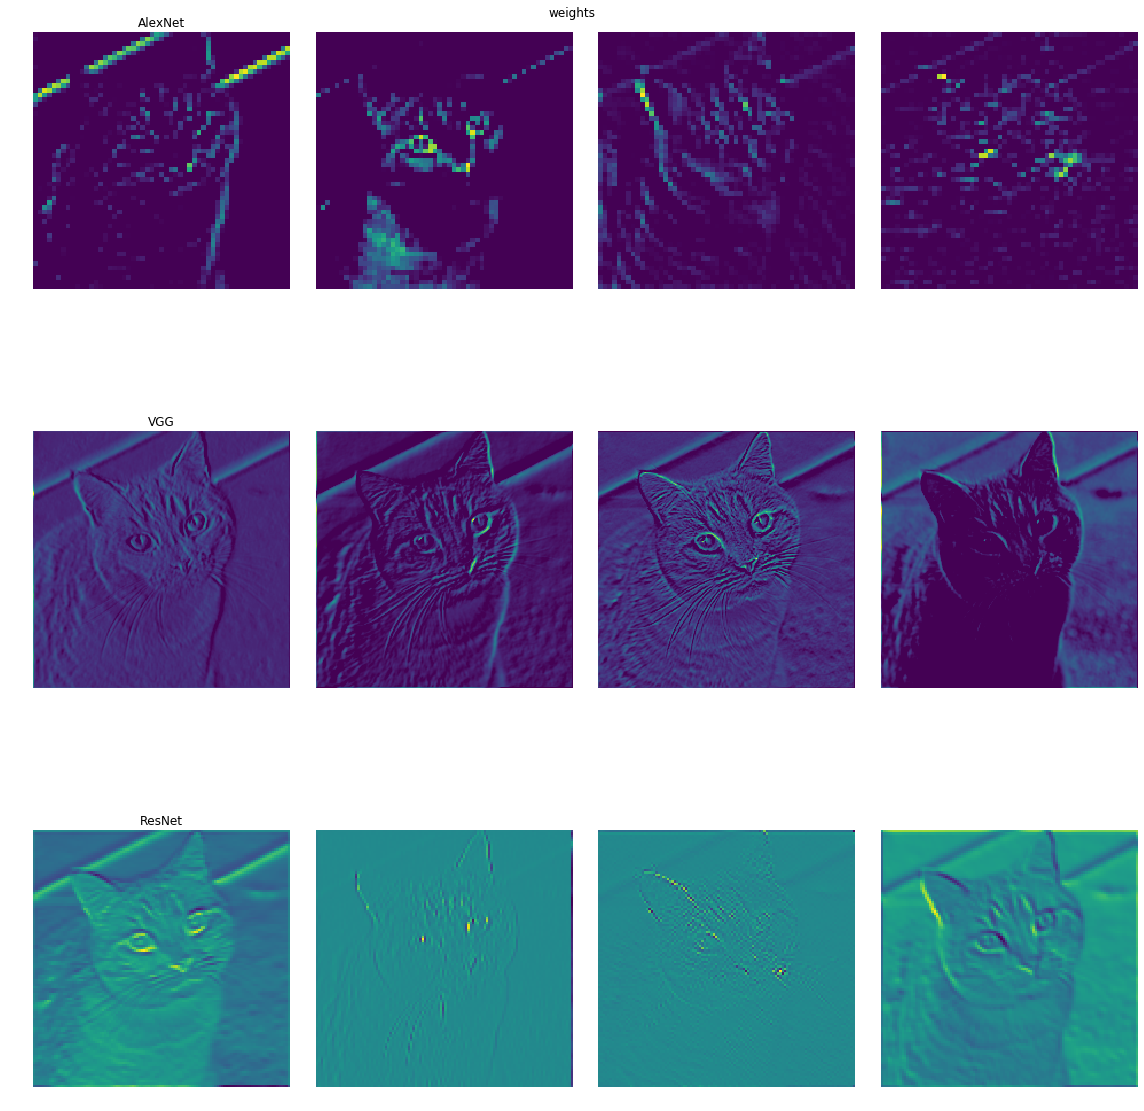

In [16]:
from datasets import load_dataset

# Încărcăm setul de date IMDb
dataset = load_dataset("imdb")

### **Pasul 3: Preprocesarea Datelor**

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

### **Pasul 4: Crearea DataLoader-elor**

In [17]:
from torch.utils.data import DataLoader

# Pregătim seturile de date pentru antrenare și validare
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

predicted class tiger cat


### **Pasul 5: Configurarea Optimizer-ului și a Scheduler-ului**

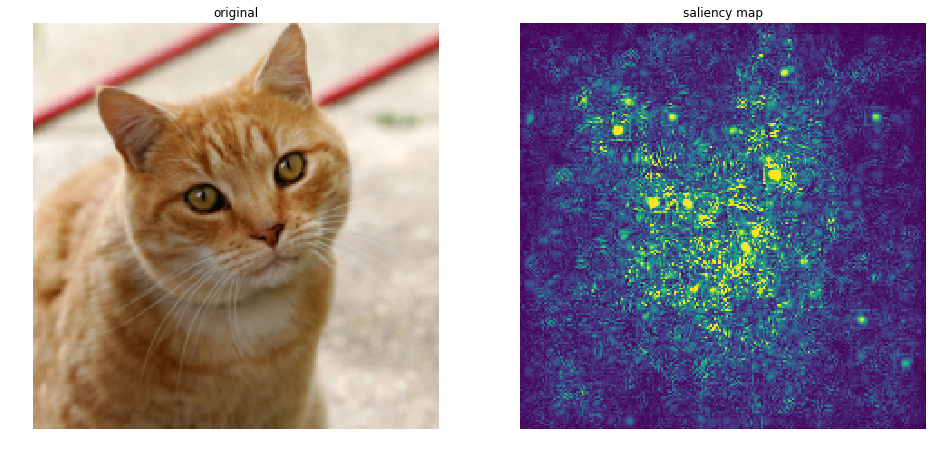

In [18]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### **Pasul 6: Antrenarea Modelului**

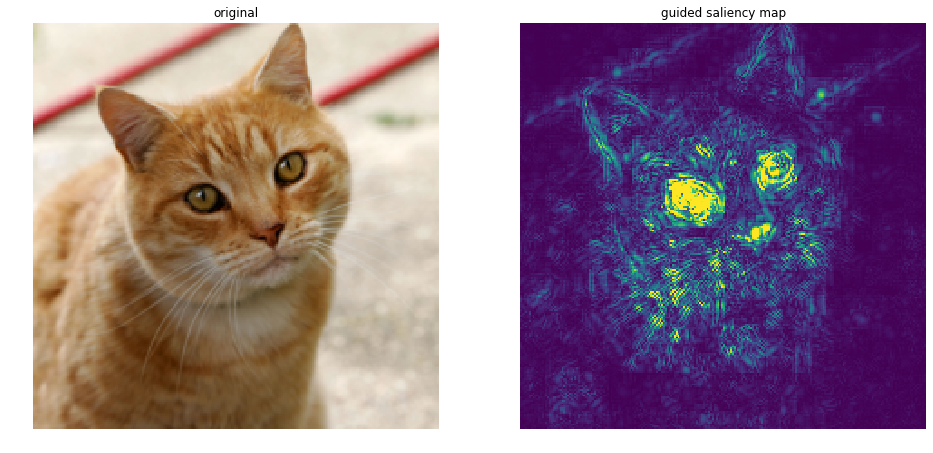

In [19]:
from tqdm.auto import tqdm

model.train()
model.to(device)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
        batch["labels"] = batch["label"]

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

### **Pasul 7: Evaluarea Modelului**

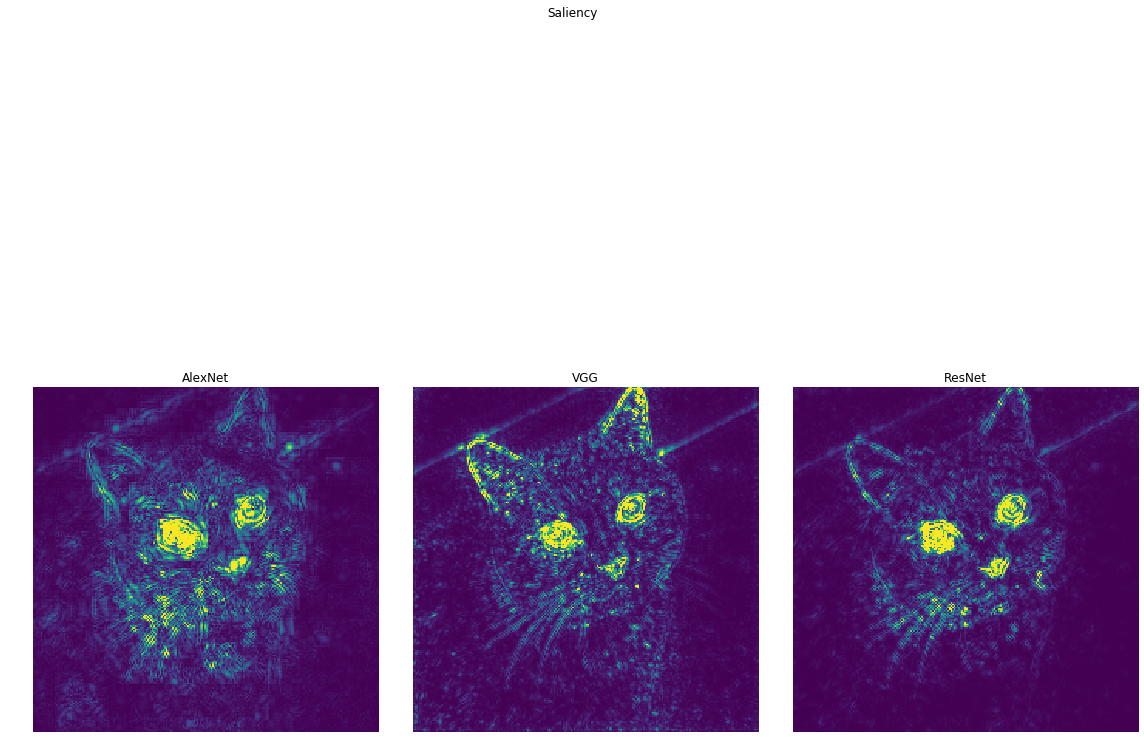

In [20]:
model.eval()

correct = 0
total = 0

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    batch["labels"] = batch["label"]
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == batch["labels"]).sum().item()
    total += predictions.size(0)

accuracy = correct / total
print(f"Acuratețea pe setul de validare: {accuracy * 100:.2f}%")

# **Observații Finale**

- **Resurse Limitate:** Google Colab oferă resurse gratuite, dar limitate. Dacă lucrați cu seturi de date mari sau modele complexe, luați în considerare utilizarea **Colab Pro** sau rularea locală.

- **Salvarea Modelului:** După antrenare, puteți salva modelul pentru utilizare ulterioară.

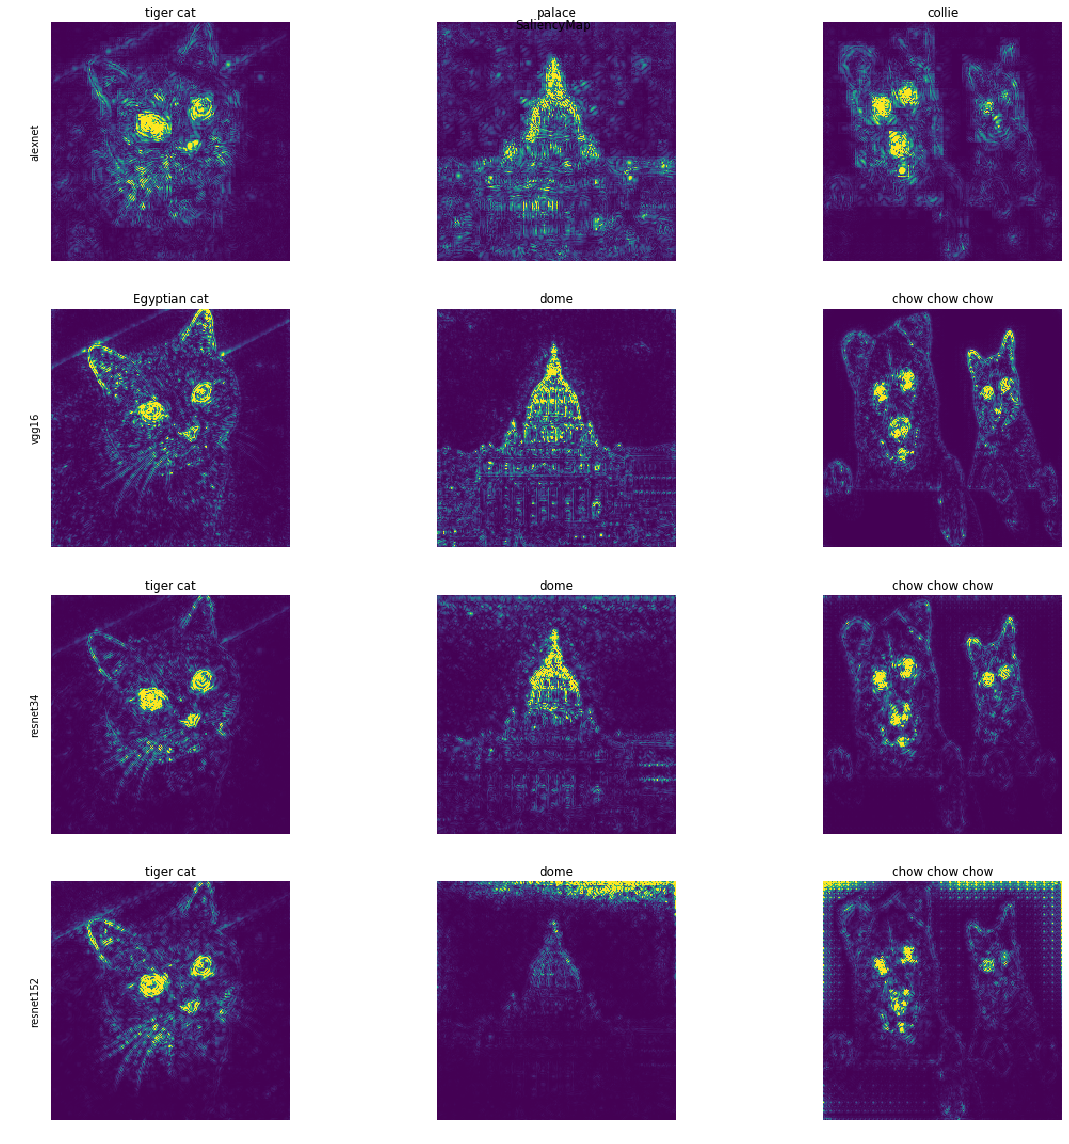

In [21]:
# Salvarea modelului și a tokenizer-ului/extractorului de caracteristici
model.save_pretrained("model-finetuned")
tokenizer_or_feature_extractor.save_pretrained("model-finetuned")

- **Încărcarea Modelului Salvat:**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Pentru NLP
model = AutoModelForSequenceClassification.from_pretrained("model-finetuned")
tokenizer = AutoTokenizer.from_pretrained("model-finetuned")

# Pentru imagini
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("model-finetuned")
feature_extractor = AutoFeatureExtractor.from_pretrained("model-finetuned")

- **Explorarea Altor Modele:** Hugging Face oferă o varietate largă de modele pre-antrenate. Vizitați [pagina lor de modele](https://huggingface.co/models?sort=trending) pentru a găsi unul care se potrivește nevoilor dvs.

# **Concluzie**

Utilizarea Google Colab cu GPU și a modelelor pre-antrenate de pe Hugging Face facilitează dezvoltarea și implementarea soluțiilor avansate de **procesare a imaginilor** și **procesare a limbajului natural**. Indiferent dacă doriți să efectuați inferență rapidă pe date noi sau să îmbunătățiți performanța unui model prin **fine-tuning**, pașii prezentați în acest ghid vă oferă un punct de plecare solid.

---

# **Resurse Suplimentare**

- **Documentație Hugging Face Transformers:** [https://huggingface.co/docs/transformers/index](https://huggingface.co/docs/transformers/index)
- **Seturi de Date Hugging Face Datasets:** [https://huggingface.co/docs/datasets/index](https://huggingface.co/docs/datasets/index)
- **Tutoriale Google Colab:** [https://colab.research.google.com/notebooks/](https://colab.research.google.com/notebooks/)

# **Exemplu Complet de Cod**

## **Pentru Imagini**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


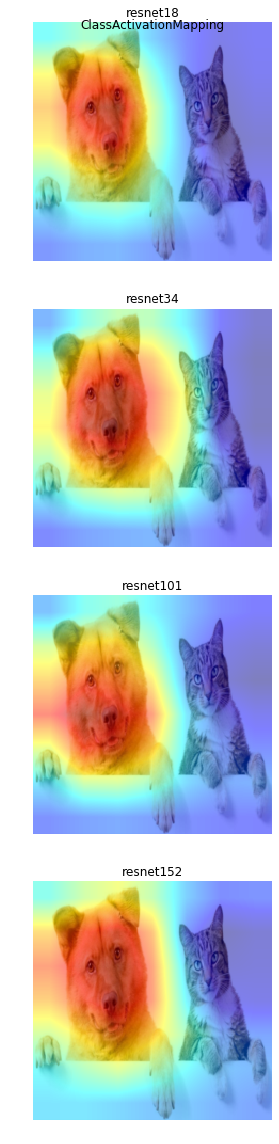

In [23]:
!pip install transformers datasets torch torchvision pillow

from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
from PIL import Image

# Alegem modelul
model_name = 'google/vit-base-patch16-224'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=10)

# Încărcăm setul de date EuroSAT
dataset = load_dataset("eurosat", "rgb", split='train[:2000]')

# Preprocesăm datele
def preprocess_images(examples):
    images = [Image.fromarray(img.astype('uint8'), 'RGB') for img in examples['image']]
    inputs = feature_extractor(images=images, return_tensors='pt')
    inputs['labels'] = examples['label']
    return inputs

prepared_dataset = dataset.map(preprocess_images, batched=True)
prepared_dataset = prepared_dataset.remove_columns(['filename', 'image'])

# DataLoader
train_dataloader = DataLoader(prepared_dataset, batch_size=8, shuffle=True)

# Configurarea optimizer-ului și scheduler-ului
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Antrenarea modelului
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

# Evaluarea modelului
model.eval()

correct = 0
total = 0

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == batch['labels']).sum().item()
    total += predictions.size(0)

accuracy = correct / total
print(f"Acuratețea pe setul de antrenament: {accuracy * 100:.2f}%")

## **Pentru NLP**

In [ ]:
!pip install transformers datasets torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm

# Alegem modelul
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Încărcăm setul de date IMDb
dataset = load_dataset("imdb")

# Preprocesăm datele
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Pregătim seturile de date
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Configurarea optimizer-ului și scheduler-ului
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Antrenarea modelului
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
        batch["labels"] = batch["label"]

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

# Evaluarea modelului
model.eval()

correct = 0
total = 0

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    batch["labels"] = batch["label"]
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == batch["labels"]).sum().item()
    total += predictions.size(0)

accuracy = correct / total
print(f"Acuratețea pe setul de validare: {accuracy * 100:.2f}%")